In [145]:
import numpy as np
from qiskit import *
import pennylane as qml
import jax
import optax
import jax.numpy as jnp
from functools import partial

# Dataset creation

In [146]:
symmetry = True
n_qubits = 8
threshold = 2

from dataset_generator import *

v = generator(int(n_qubits/2),2)
delta_l = Dealtal_calculation(v)

X = []
Y = []

for i in range(10000):
    v = list(generator(int(n_qubits/2),int(i%4)))
    if v in X:
        pass
    else:
        v = [int(v[j]) for j in range(len(v))]
        X.append(v)
        if Dealtal_calculation(v)<threshold:
            Y.append(1)
        else:
            Y.append(-1)
print(Y.count(-1),Y.count(1))

24 45


In [150]:
shuffle_indices = np.random.permutation(len(X))
train_size = int(len(X)*0.7)

train_indices = np.array(shuffle_indices[:train_size])
test_indices = np.array(shuffle_indices[train_size:])

x_train, y_train = np.take(X, train_indices, axis=0), np.take(Y, train_indices, axis=0)
x_test, y_test = np.take(X, test_indices, axis=0), np.take(Y, test_indices, axis=0)

x_train = jnp.array(x_train)
x_test = jnp.array(x_test)

for x,y in zip(x_train[:5, :], y_train[:5]):
    print(x,y)

print()

[0 1 0 0 1 1 1 0] 1
[0 0 0 0 0 0 1 1] 1
[0 0 0 0 0 0 0 0] 1
[0 1 0 0 0 0 1 0] 1
[1 0 1 1 1 1 0 1] -1



# Circuit building

In [151]:
symmetry = True
n_qubits = 8

def Rotation():
    for i in range(n_qubits-1):
        qml.SWAP(wires=[i,i+1])

def Inverse_Rotation():
    for i in range(n_qubits-2,-1,-1):
        qml.SWAP(wires=[i,i+1])
 
def Reflection():
    for i in range(1,int(n_qubits/2)):
        qml.SWAP(wires=[i,n_qubits-i])

In [152]:
def encode_data(x, r, sigma):    
    for i in np.arange(r):
        Rotation()
    qml.Barrier(wires=range(n_qubits), only_visual=True)
    for j in np.arange(sigma):
        Reflection()
    qml.Barrier(wires=range(n_qubits), only_visual=True)
    for i in np.arange(n_qubits):
        qml.RX(np.pi*x[i], wires=i)
    qml.Barrier(wires=range(n_qubits), only_visual=True)
    for j in np.arange(sigma):
        Reflection()
    qml.Barrier(wires=range(n_qubits), only_visual=True)    
    for i in np.arange(r):
        Inverse_Rotation()

def basic_ansatz(thetas,):
    k = 0
    for lay in range(sublayers):
        basic_ansatz_layer(thetas[k:params_per_sublayer+k])
        k += params_per_sublayer

def basic_ansatz_layer(thetas):
    # for i in range(n_qubits):
    #     qml.RX(thetas[i], wires=i)
    # k+=n_qubits
    # for i in range(n_qubits):
    #     qml.RY(thetas[i+k], wires=i)
    # k+=n_qubits
    # for i in range(n_qubits):
    #     qml.RX(thetas[i+k], wires=i)
    # k+=n_qubits

    for i in range(n_qubits):
        qml.RX(thetas[0], wires=i)
    for i in range(n_qubits):
        qml.RY(thetas[1], wires=i)
    for i in range(n_qubits):
        qml.RX(thetas[2], wires=i)
    
    #Blocco A - entanglement
    for i in range(0,n_qubits,2):
        qml.CPhase(thetas[3], wires=[i,i+1]) 
    
    for i in range(1,n_qubits,2):
        qml.CPhase(thetas[3], wires=[i,(i+1)%n_qubits])
    

def symmetry_output(wires):
    op_final = qml.expval(qml.PauliZ(0)@qml.PauliZ(1)@qml.PauliZ(2)@qml.PauliZ(3)@qml.PauliZ(4)@qml.PauliZ(5)@qml.PauliZ(6)@qml.PauliZ(7))  
    return op_final

In [153]:
device = qml.device("default.qubit.jax", wires=n_qubits)
    
# @partial(jax.jit, static_argnums=(2,3))
@qml.qnode(device,interface='jax')#, diff_method='adjoint') 
def circuit(x, thetas, r, sigma):
    j = 0
    for lay in range(layers):
        encode_data(x, r, sigma)
        qml.Barrier(wires=range(n_qubits),only_visual=True)
        basic_ansatz(thetas[j:j+(params_per_sublayer)*sublayers],)
        j += (params_per_sublayer)*sublayers
        #symmetry_ansatz(thetas)
    qml.Barrier(wires=range(n_qubits),only_visual=True)

    # return qml.expval(qml.PauliZ(wires=0)), qml.expval(qml.PauliZ(wires=1)), qml.expval(qml.PauliZ(wires=2))
    return symmetry_output(wires=range(n_qubits))

# Train Symmetric


Split data into test and train data

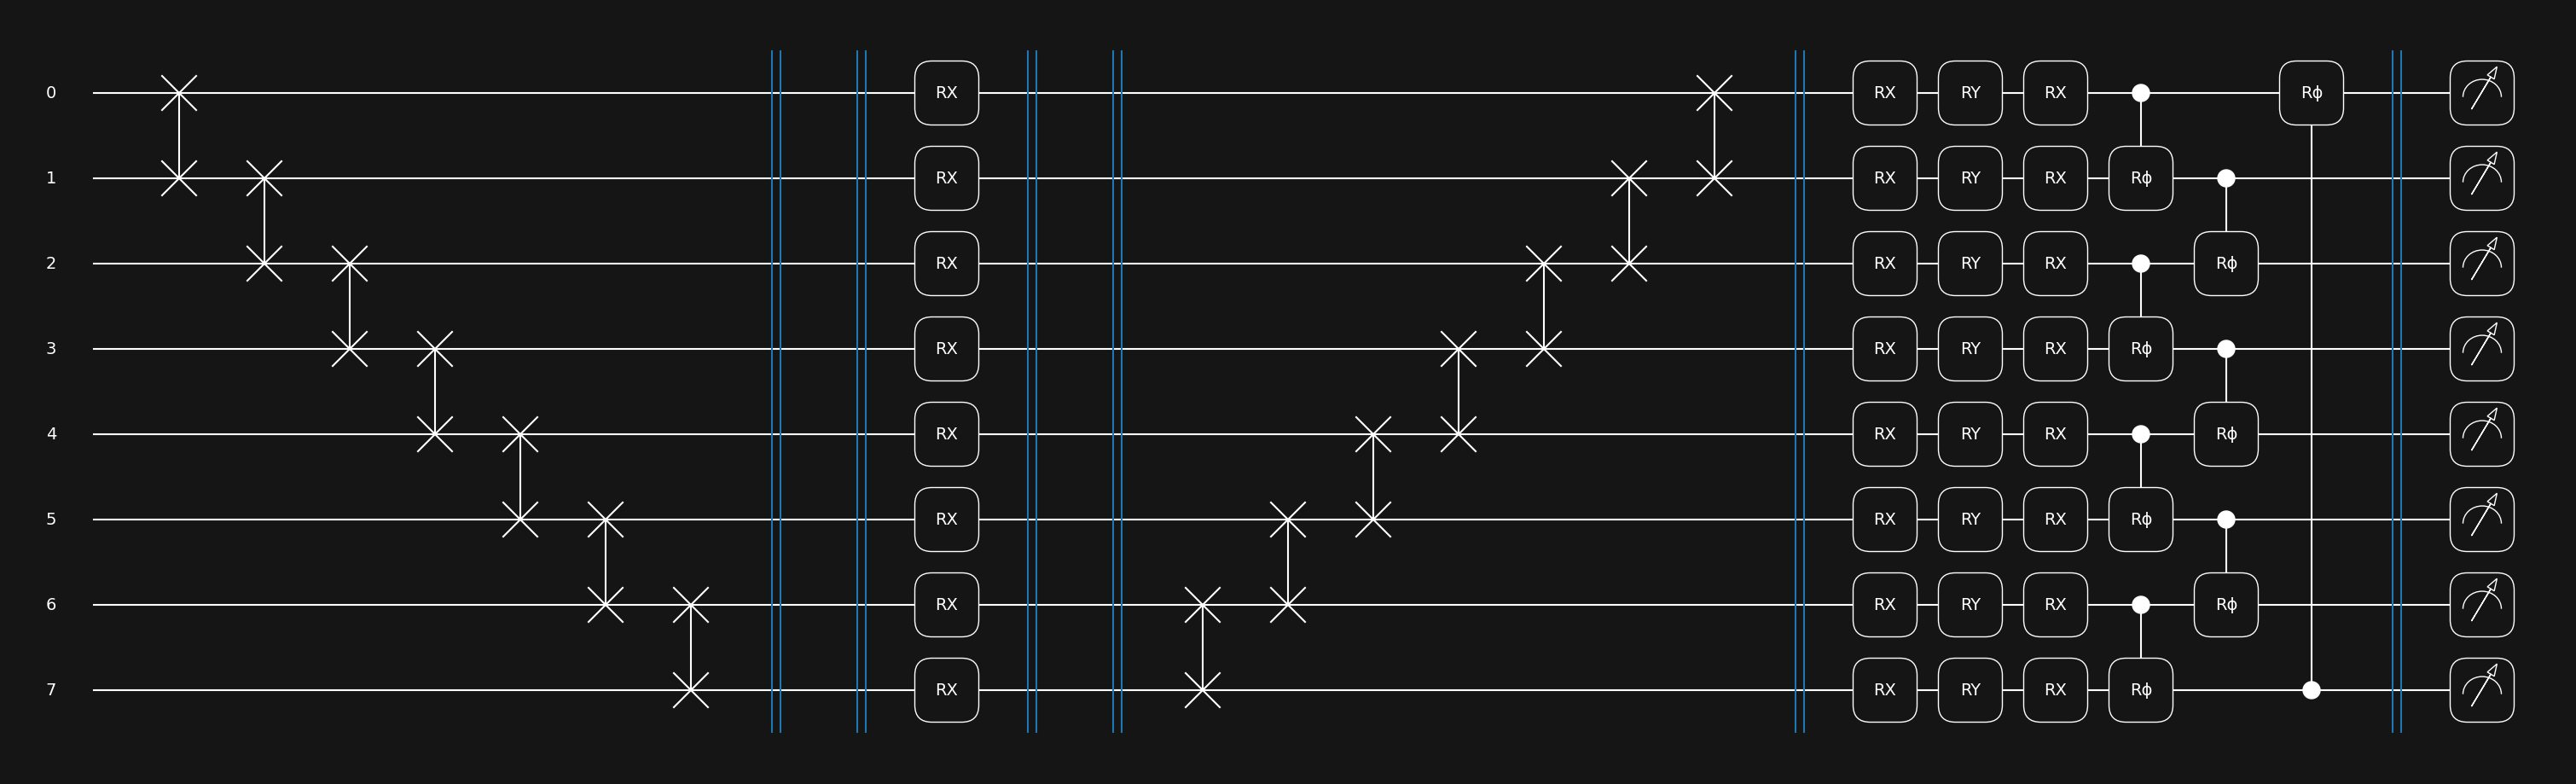

In [154]:
layers = 1
sublayers = 1
params_per_sublayer = 4*n_qubits
qml.draw_mpl(circuit, style = 'black_white_dark')([1,0,1,1,1,1,0,0],np.arange(params_per_sublayer*layers*sublayers),1,0)
plt.savefig('./symmetric_circuit.pdf')

In [158]:
# @jax.jit
def cross_entropy_loss(y_true, y_pred):
    return -jnp.mean(jnp.sum(jnp.log(y_pred) * y_true, axis=1))
    
# @jax.jit
def calculate_ce_cost(X, y, theta):
    y = jnp.array(y)
    # # qml.draw_mpl(circuit, decimals=2,expansion_strategy="device")(X[0].tolist(), theta)
    # # plt.show()
    yp = []
    for r in jnp.arange(n_qubits-1):
        for sigma in jnp.array([0,1]):
            yp_tmp = qnn(X, theta,r, sigma) ##TO DO: - modify the measurement scheme so as to fit softmax
                                                   # - change the labels to 0 and 1 instead of -1 and 1
            yp = jax.nn.softmax(yp)
            yp.append(yp_tmp)

    yp = jnp.array(yp)
    yp = jnp.mean(yp, axis=0)
    

    cost = cross_entropy_loss(y, yp)

    return cost

# @jax.jit
def calculate_mse_cost(X, y, theta):
    y = jnp.array(y)
    # # qml.draw_mpl(circuit, decimals=2,expansion_strategy="device")(X[0].tolist(), theta)
    # # plt.show()
    yp = []
    for r in jnp.arange(n_qubits-1):
        for sigma in jnp.array([0,1]):
            yp_tmp = qnn(X, theta,r, sigma) 
            yp.append(yp_tmp)

    yp = jnp.array(yp)
    yp = jnp.mean(yp, axis=0)
    
    cost = jnp.mean((yp - y) ** 2)
    return cost

# @jax.jit
def calculate_mse_cost_and_accuracy(x,y, theta,):
    y = jnp.array(y)
    # qml.draw_mpl(circuit, decimals=2,expansion_strategy="device")(X[0].tolist(), theta)
    # plt.show()
    yp = []
    for r in range(n_qubits-1):
        for sigma in [0,1]:
            yp_tmp = qnn(x, theta,r, sigma) 
            yp.append(yp_tmp)
    yp = jnp.array(yp)
    yp = yp.mean(axis=0)

    cost = jnp.mean((yp - y) ** 2)
    rounded = jnp.where(yp>0, 1, -1)
    
    return cost, sum(rounded==y)/x.shape[0]

# Optimization update step
# @jax.jit
def optimizer_update(opt_state, params, x, y, ):
    loss, grads = jax.value_and_grad(lambda theta: calculate_mse_cost(x, y, theta,))(params)
    updates, opt_state = optimizer.update(grads, opt_state)
    # print('updates------\n')
    # f=np.array(drop_rot).flatten()
    # h = optax.apply_updates(params, updates)
    # for i in zip(jnp.asarray(updates),f, params, h):
    #              print(i)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss

In [159]:
sublayers = 1
layers = 3
params_per_sublayer = 4*n_qubits #unsure
qnn_batched = jax.vmap(circuit, (0, None, None, None))
qnn = (qnn_batched)#jax.jit

In [160]:
starting_seed = 123

n_runs = 1
epochs = 20 #CHANGE
stoc_steps = 5
optimizer = optax.adam(learning_rate=0.01)
seed = 123

costs_per_comb = []
test_costs_per_comb = []
opt_params_per_comb = []

key = jax.random.PRNGKey(seed)
initial_params = jax.random.normal(key, shape=((params_per_sublayer)*layers*sublayers,))
key = jax.random.split(key)[0]

params = jnp.copy(initial_params)

opt_state = optimizer.init(initial_params)
costs = []
test_costs = []
train_accs = []
test_accs = []
print()
for epoch in range(epochs):
    for step in range(stoc_steps):
        ## TO DO: migliorare la formazione delle batches
        ##      ---> dividere dataset in batch di size fissata 
        #           che cambiano ad ogni epoca
        #           (al momento per ogni step si campiona in modo casuale
        #            una batch --> potrebbe avere elementi comuni o non averne alcuni)
        idxs = jax.random.choice(key, jnp.array(list(range(x_train.shape[0]))), shape=(15,))
        key = jax.random.split(key)[0]
        #######################################################
        params, opt_state, cost = optimizer_update(opt_state, params, x_train[idxs,:], y_train[idxs])
        cost, acc = calculate_mse_cost_and_accuracy(x_train, y_train,params)
        costs.append(cost)
        train_accs.append(acc)
        test_cost, test_acc = calculate_mse_cost_and_accuracy(x_test, y_test, params, )
        test_costs.append(test_cost)
        test_accs.append(test_acc)
        print(step, 'Train cost:',cost,'--- Test cost:',test_cost)
    print(f"layers:{layers}, p:{sublayers}, epoch {epoch}/{epochs}",'--- Train cost:',cost,'--- Test cost:',test_cost, end='\r')
costs_per_comb.append(costs)
test_costs_per_comb.append(test_costs)
opt_params_per_comb.append(params)



0 Train cost: 0.9821345 --- Test cost: 0.9996801
1 Train cost: 0.95732754 --- Test cost: 0.9840171
2 Train cost: 0.93077004 --- Test cost: 0.9668454
3 Train cost: 0.8990053 --- Test cost: 0.9471233
4 Train cost: 0.8635406 --- Test cost: 0.9259985
0 Train cost: 0.82741404 --- Test cost: 0.905205306 --- Test cost: 0.9259985
1 Train cost: 0.79631734 --- Test cost: 0.8865524
2 Train cost: 0.76662225 --- Test cost: 0.8693679
3 Train cost: 0.7401794 --- Test cost: 0.8546696
4 Train cost: 0.7199241 --- Test cost: 0.84143025
0 Train cost: 0.7029049 --- Test cost: 0.8288989241 --- Test cost: 0.84143025
1 Train cost: 0.68856907 --- Test cost: 0.81688136
2 Train cost: 0.67650986 --- Test cost: 0.8057312
3 Train cost: 0.6660103 --- Test cost: 0.7940183
4 Train cost: 0.6570022 --- Test cost: 0.78236353
0 Train cost: 0.64948297 --- Test cost: 0.771313722 --- Test cost: 0.78236353
1 Train cost: 0.6435628 --- Test cost: 0.7611565
2 Train cost: 0.6397325 --- Test cost: 0.75322723
3 Train cost: 0.63765

In [161]:
import os

dir_path = '.'
data_folder_non_symm = dir_path+f'/symmetric/{layers}l-{sublayers}p' 
os.makedirs(data_folder_non_symm,  0o755,  exist_ok=True)
#train_cost
np.save(data_folder_non_symm+'/train_cost.npy', list(costs))
np.save(data_folder_non_symm+'/test_cost.npy', list(test_costs))
np.save(data_folder_non_symm+'/train_accs.npy', list(train_accs))
np.save(data_folder_non_symm+'/test_accs.npy', list(test_accs))
np.save(data_folder_non_symm+'/opt_params.npy', list(params))
#testcost
#train acc
#testacc
#opt params


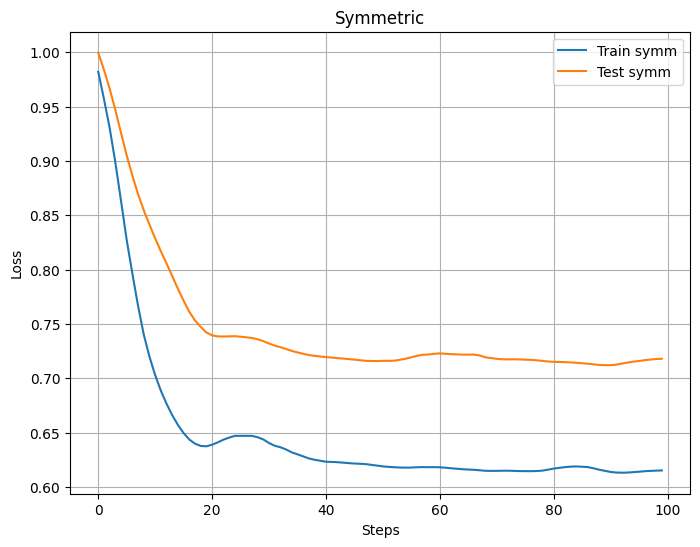

In [171]:
import matplotlib.pyplot as plt


test_cost_symm = np.load(data_folder_non_symm+'/test_cost.npy', )
train_cost_symm = np.load(data_folder_non_symm+'/train_cost.npy', )
plt.figure(figsize=(8,6))
plt.title('Symmetric')
plt.plot(train_cost_symm, label='Train symm')#
plt.plot(test_cost_symm, label='Test symm')

plt.xlabel('Steps')
plt.ylabel('Loss')
plt.grid()
plt.legend()

plt.savefig(data_folder_non_symm+'/loss_symm.pdf', transparent=True) 

plt.show()

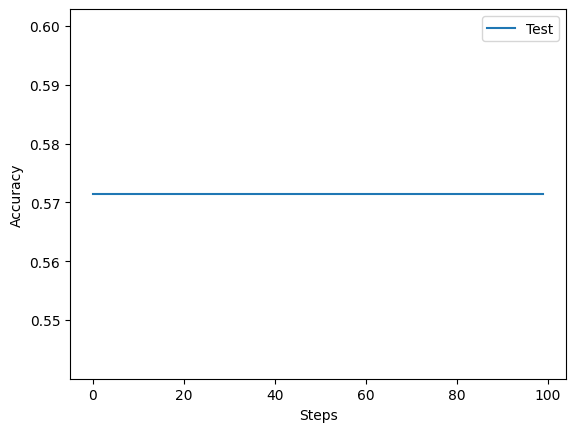

In [170]:
plt.plot(train_accs, label='Train')
plt.plot(test_accs, label='Test')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.legend()

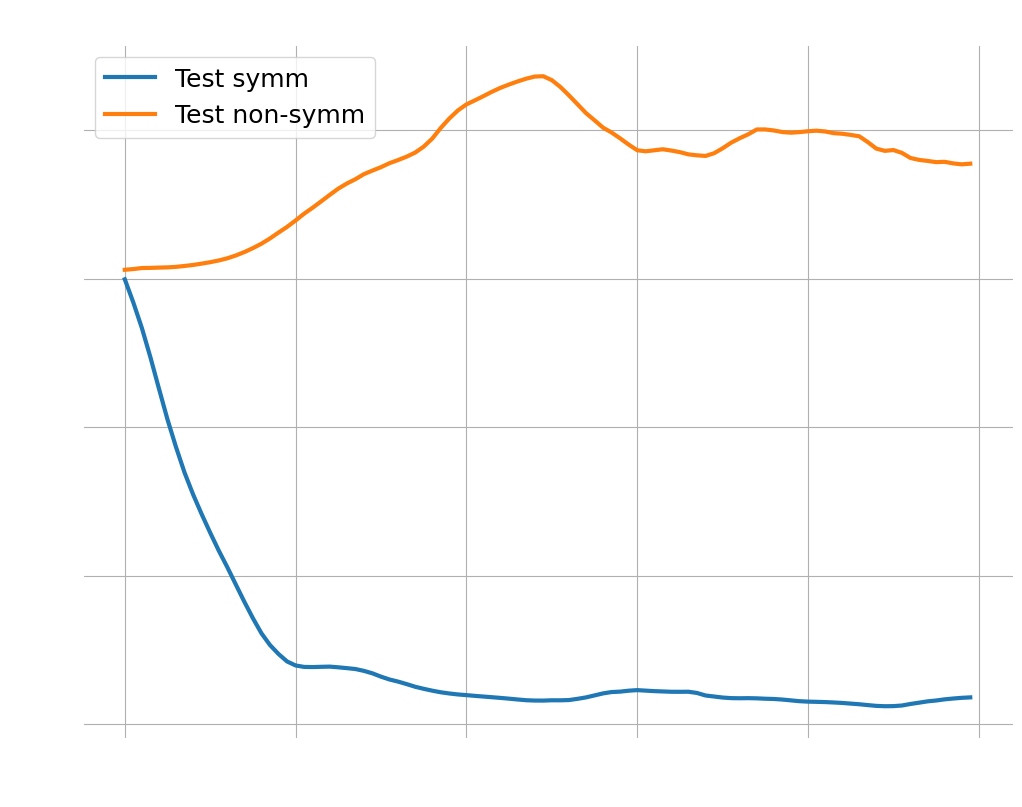

In [164]:
max_epoch = 300

dir_path = '.'
data_folder_symm = dir_path+f'/symmetric/{layers}l-{sublayers}p' 
data_folder_part_symm = dir_path+f'/asymmetric/{layers}l-{sublayers}p' 

fig, ax = plt.subplots(figsize=(12, 9))
w='white'
plt.title(f'Loss - Layers: {layers}, sub-layers: {sublayers}', fontsize=25, c=w)
test_cost =np.load(data_folder_symm+'/test_cost.npy', )
plt.plot(test_cost[:max_epoch], label='Test symm',linewidth=3)

test_cost_nonsymm = np.load(data_folder_part_symm+'/test_cost.npy', )
plt.plot(test_cost_nonsymm[:max_epoch], label='Test non-symm',linewidth=3)


plt.xlabel('Steps', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.legend(fontsize=18)
plt.grid()

ax.spines['bottom'].set_color(w)
ax.spines['top'].set_color(w)
ax.spines['left'].set_color(w)
ax.spines['right'].set_color(w)
ax.xaxis.label.set_color(w)
ax.yaxis.label.set_color(w)
ax.tick_params(axis='x', colors=w, labelsize=15)
ax.tick_params(axis='y', colors=w, labelsize=15)

plt.savefig("schwinger_comparison_cost.png", transparent=True) 

plt.show()

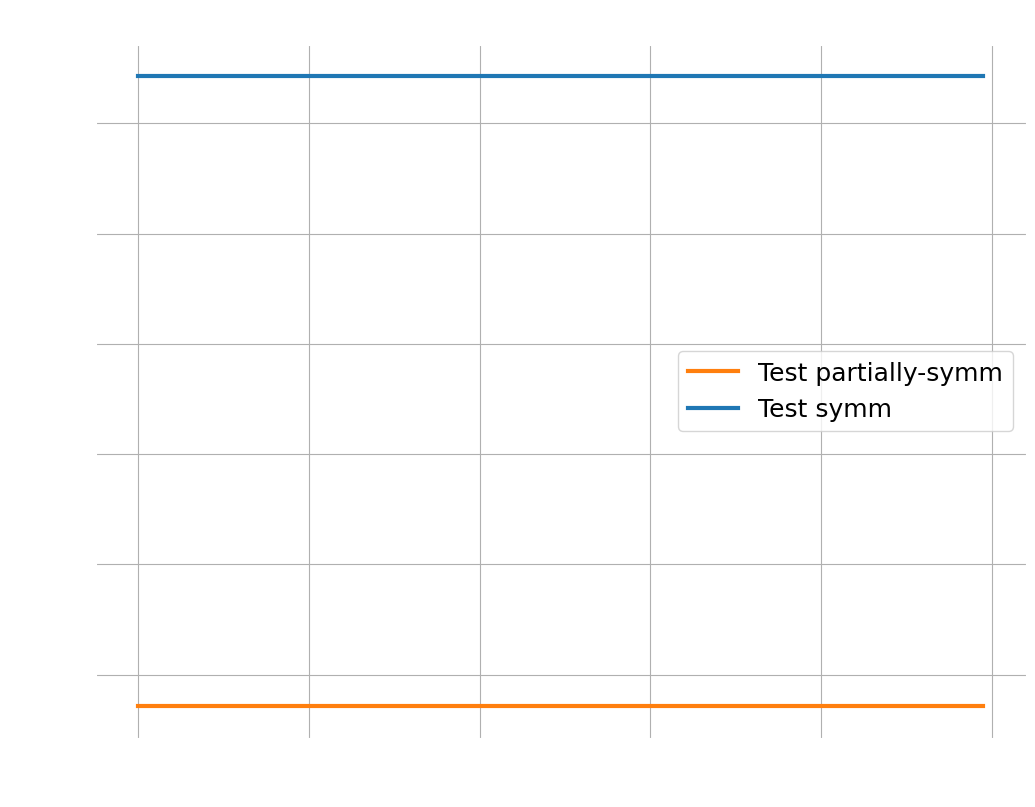

In [165]:
max_epoch = 500

dir_path = '.'
data_folder_symm = dir_path+f'/symmetric/{layers}l-{sublayers}p' 
data_folder_part_symm = dir_path+f'/asymmetric/{layers}l-{sublayers}p' 

fig, ax = plt.subplots(figsize=(12, 9))

w = 'white'
plt.title(f'Accuracy - Layers: {layers}, sub-layers: {sublayers}', c=w, fontsize=25 )

test_accs_nonsymm = np.load(data_folder_part_symm+'/test_accs.npy')
plt.plot(test_accs_nonsymm[:max_epoch], label='Test partially-symm', linewidth=3, c='#ff7f0e')

test_accs =np.load(data_folder_symm+'/test_accs.npy', )
plt.plot(test_accs[:max_epoch], label='Test symm', linewidth=3, c='#1f77b4')

plt.xlabel('Steps', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
plt.legend( fontsize=18)
plt.grid()

ax.spines['bottom'].set_color(w)
ax.spines['top'].set_color(w)
ax.spines['left'].set_color(w)
ax.spines['right'].set_color(w)
ax.xaxis.label.set_color(w)
ax.yaxis.label.set_color(w)
ax.tick_params(axis='x', colors=w, labelsize=15 )
ax.tick_params(axis='y', colors=w, labelsize=15)

plt.savefig("schwinger_comparison_accs.png", transparent = True) 

plt.show()
